In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
while not os.getcwd().endswith('Laboratorio_SiPM'):
    os.chdir('..')

import sys
sys.path.append('Config')
from lablib import *

### Funzioni utili

In [39]:
root_path = r'Dati/Parte 2/Caratterizzazione_impulso/'
skip = 18

def read_data(filename, titles = ['Time', 'V']):
    df = read_corretto(root_path + filename, skip, titles)

    # Sostituire tutte le istanze di "," con "" nelle colonne: 'V', 'Time'
    df['V'] = df['V'].str.replace(",", "", case=False, regex=False)
    df['Time'] = df['Time'].str.replace(",", "", case=False, regex=False)

    # Converte le colonne in float
    df = df.astype(float)

    return df

def _crop_df(df, N, thr):
    df = crop_df(df, N, thr)
    df.index = np.arange(len(df))
    return df


def quick_plot(df):
    plt.plot(df['Time'], df['V'])
    plt.xlabel('Time')
    plt.ylabel('V')
    plt.title('Signal')
    plt.show()

def find_max(df):
    max_index = df['V'].idxmax()
    max_value = df['V'][max_index]

    return max_index, max_value

def exp_dec(x, a, b, c):
    return a * np.exp(-b * x) + c

def exp_cre(x, a, b, c, x0):
    return a * (1 - np.exp(-b * (x-x0))) + c

def rise_fall(df):
    max_index, _ = find_max(df)

    rise_time = df['Time'][:max_index]
    fall_time = df['Time'][max_index:]
    rise_voltage = df['V'][:max_index]
    fall_voltage = df['V'][max_index:]

    rise = pd.DataFrame({'Time': rise_time, 'V': rise_voltage})
    fall = pd.DataFrame({'Time': fall_time, 'V': fall_voltage})
    return rise, fall



## BGO

In [40]:
def log(x, a, b, x0):
    return a * np.log(x-x0) + b

def pol3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def composto(x, a, b, c, d, e):
    return a * np.exp(-b * x) + c * (1 - np.exp(-d * (x-e))) + e

### Na

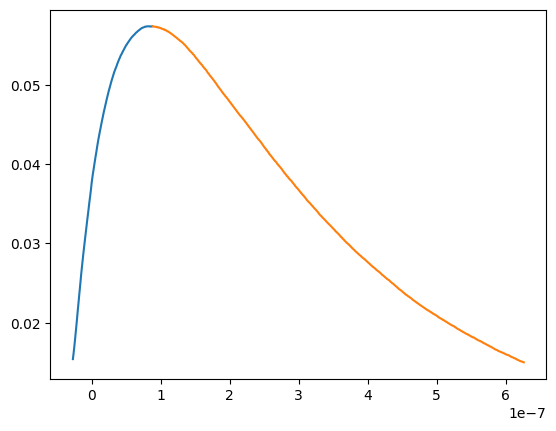

In [60]:
bgo_na = pd.read_csv(root_path + 'BGO_Na22.CSV')
bgo_na = _crop_df(bgo_na, 10, .015)

bgo_na_rise, bgo_na_fall = rise_fall(bgo_na)
bgo_na_ers1 = [0.001] * len(bgo_na_rise)
bgo_na_ers2 = [0.001] * len(bgo_na_fall)

plt.plot(bgo_na_rise['Time'], bgo_na_rise['V'], label='Rise')
plt.plot(bgo_na_fall['Time'], bgo_na_fall['V'], label='Fall')

In [61]:
pars1, vals1, ers1, *other1 = LS_fit_lims(bgo_na_rise['Time'], bgo_na_rise['V'], bgo_na_ers1, exp_cre, 
                                          limits = [['a', (0, 1)], ['b', (10_0000, None)], ['x0', (-10,10)]], a=.01, b=10, c=0, x0=0)

#pars1, vals1, ers1, *other1 = LS_fit(bgo_na_rise['Time'], bgo_na_rise['V'], bgo_na_ers1, pol3, a=1, b=0, c=0, d=0)

/tmp/ipykernel_36100/21562801.py:39: RuntimeWarning: overflow encountered in exp
  return a * (1 - np.exp(-b * (x-x0))) + c


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2109 (χ²/ndof = 18.8)      │              Nfcn = 703              │
│ EDM = 10 (Goal: 0.0002)          │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.818   │   0.007   │            │            │    0    │    1    │       │
│ 1 │ b    │  1.818e6  │  0.025e6  │            │            │ 100000  │         │       │
│ 2 │ c    │  -0.581   │   0.009   │            │            │   -10   │   10    │       │
│ 3 │ x0   │  -770e-9  │   6e-9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────┐
│    │                 a                 b                 c                x0 │
├────┼─────────────────────────────────────────────────────────────────────────┤
│  a │          5.36e-05          66.06651          -0.06e-3     -27.19419e-12 │
│  b │          66.06651          6.38e+08        -133.34606 41.97274148968e-6 │
│  c │          -0.06e-3        -133.34606          7.66e-05      28.31035e-12 │
│ x0 │     -27.19419e-12 41.97274148968e-6      28.31035e-12          3.99e-17 │
└────┴─────────────────────────────────────────────────────────────────────────┘

In [62]:
pars2, vals2, ers2, *other2 = LS_fit(bgo_na_fall['Time'], bgo_na_fall['V'], bgo_na_ers2, exp_dec, a=1, b=0.01, c=0)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 289.7 (χ²/ndof = 0.5)      │              Nfcn = 700              │
│ EDM = 3.79e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  87.5e-3  │  0.9e-3   │            │            │         │         │       │
│ 1 │ b    │  1.84e6   │  0.05e6   │            │            │         │         │       │
│ 2 │ c    │  -0.0137  │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │           a           b           c │
├───┼─────────────────────────────────────┤
│ a │    8.64e-07 -40.5976988     -1.1e-6 │
│ b │ -40.5976988     2.1e+09  53.0029820 │
│ c │     -1.1e-6  53.0029820    1.36e-06 │
└───┴─────────────────────────────────────┘

In [63]:
#parsx, valsx, ersx, *otherx = LS_fit(bgo_na['Time'], bgo_na['V'], [.001 for _ in bgo_na['Time']], composto, a=1, b=0.01, c=0, d=0.01, e=0.01)

### Co

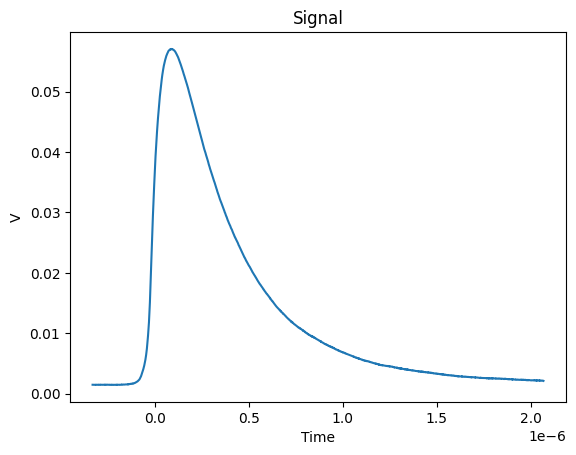

In [64]:
bgo_co = pd.read_csv(root_path + 'BGO_Co60.CSV')
quick_plot(bgo_co)

## CSI

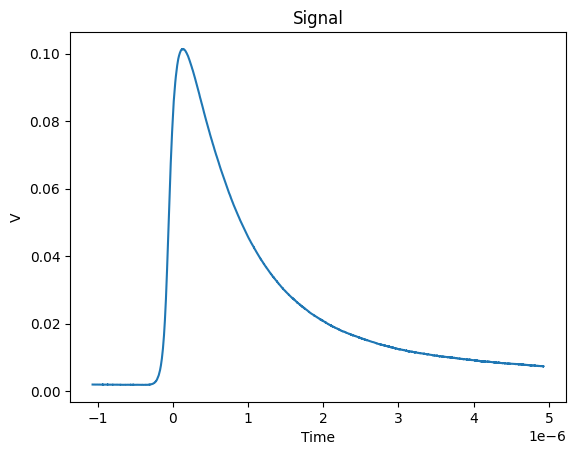

In [65]:
csi_na = pd.read_csv(root_path + 'CSI_Na22.CSV')
quick_plot(csi_na)

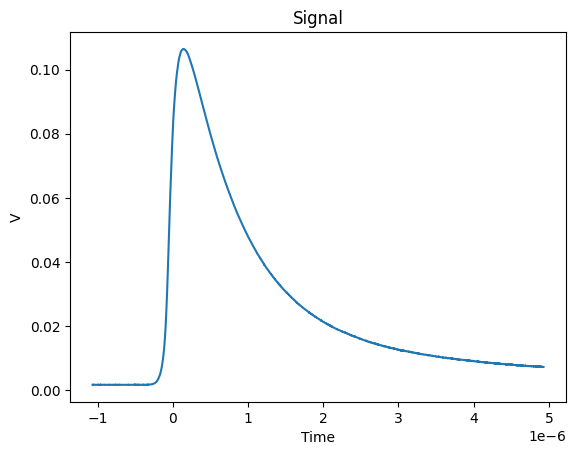

In [66]:
csi_co = pd.read_csv(root_path+'CSI_Co60.CSV')
quick_plot(csi_co)

## Lyso

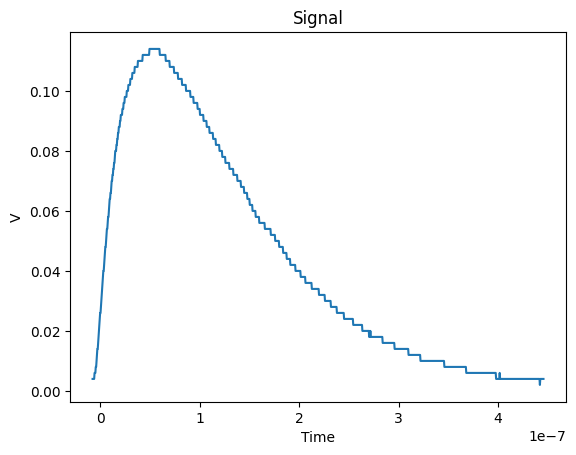

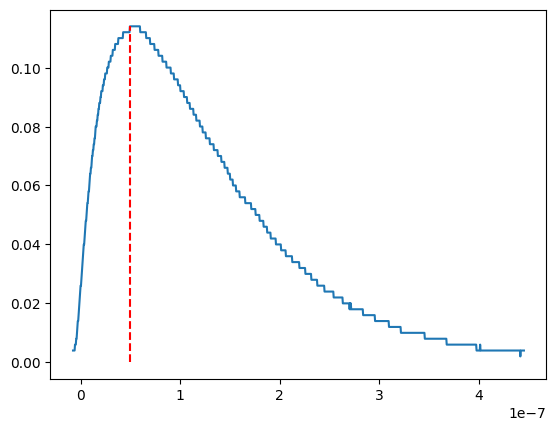

In [67]:
lyso = read_data('LySO/dat.CSV')
lyso = crop_df(lyso, 10, .002)
#lyso_rise, lyso_fall = rise_fall(lyso)
quick_plot(lyso)

lyso_ers = [.002] * len(lyso['Time'])

max_index_lyso, max_lyso = find_max(lyso)

plt.plot(lyso['Time'], lyso['V'])
plt.vlines(lyso['Time'][max_index_lyso], 0, max_lyso, color='r', linestyle='--')
plt.show()

In [68]:
# descend fit
pars_lyso, vals_lyso, ers_lyso, *other_lyso = LS_fit(lyso['Time'][max_index_lyso:], lyso['V'][max_index_lyso:], lyso_ers[max_index_lyso:], expon, a=1, b=1)

NameError: name 'expon' is not defined

In [ ]:

plt.plot(lyso_fall['Time'], lyso_fall['V'])